In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
data=pd.read_csv('scaled_dataset.csv')

In [7]:
data.head()

,MSSubClass,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtQual,BsmtCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.2,-0.257516,-0.267660,0.0,0.652174,0.243243,1.193303,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.6,0.464671,0.029682,3.0,0.065217,-0.486486,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,-0.100761,0.399288,0.0,0.608696,0.216216,0.986301,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,-0.535329,0.017513,0.0,-1.260870,-0.648649,0.000000,0.0,-1.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,0.2,0.634651,0.951802,0.0,0.586957,0.162162,2.130898,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


MODELS WITHOUT FEATURE SELECTION (RIDGE 94%)


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
dataset_path = 'scaled_dataset.csv'
df = pd.read_csv(dataset_path)

X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# K-Fold Cross-Validation (Validation set is selected in each fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (Degree=2)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

# Train and evaluate models using K-Fold Cross-Validation
results = {}
for name, model in models.items():
    mae_list, mse_list, rmse_list, r2_list = [], [], [], []

    for train_idx, val_idx in kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae_list.append(mean_absolute_error(y_val, y_pred))
        mse_list.append(mean_squared_error(y_val, y_pred))
        rmse_list.append(np.sqrt(mse_list[-1]))
        r2_list.append(r2_score(y_val, y_pred))

    results[name] = (np.mean(mae_list), np.mean(mse_list), np.mean(rmse_list), np.mean(r2_list))

# Display results
print("\nModel Performance on Validation Set (K-Fold CV):")
for name, (mae, mse, rmse, r2) in results.items():
    print(f"{name}:\n  MAE: {mae:.4f}\n  MSE: {mse:.4f}\n  RMSE: {rmse:.4f}\n  R2 Score: {r2:.4f}\n")

# Select best model (highest average R2 score)
best_model_name = max(results, key=lambda x: results[x][3])
best_model = models[best_model_name]
print(f"Best Model Before Tuning: {best_model_name}\n")

# Hyperparameter tuning for the best model
if isinstance(best_model, Ridge) or isinstance(best_model, Lasso):
    param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
elif "Polynomial" in best_model_name:
    param_grid = {"polynomialfeatures__degree": [2, 3, 4]}
else:
    param_grid = {}

if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_val, y_train_val)
    tuned_model = grid_search.best_estimator_

    # Training Error
    y_train_pred = tuned_model.predict(X_train_val)
    train_mae = mean_absolute_error(y_train_val, y_train_pred)
    train_mse = mean_squared_error(y_train_val, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_val, y_train_pred)

    # Test Error
    y_test_pred = tuned_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nModel Performance After Tuning:")
    print(f"{best_model_name} (Training Set):")
    print(f"  MAE: {train_mae:.4f}\n  MSE: {train_mse:.4f}\n  RMSE: {train_rmse:.4f}\n  R2 Score: {train_r2:.4f}\n")

    print(f"{best_model_name} (Test Set):")
    print(f"  MAE: {test_mae:.4f}\n  MSE: {test_mse:.4f}\n  RMSE: {test_rmse:.4f}\n  R2 Score: {test_r2:.4f}\n")

    print(f"Best Parameters: {grid_search.best_params_}")




Model Performance on Validation Set (K-Fold CV):
Linear Regression:
  MAE: 0.0107
  MSE: 0.0015
  RMSE: 0.0333
  R2 Score: 0.9802

Polynomial Regression (Degree=2):
  MAE: 0.0517
  MSE: 0.0193
  RMSE: 0.1367
  R2 Score: 0.7341

Ridge Regression:
  MAE: 0.0130
  MSE: 0.0013
  RMSE: 0.0309
  R2 Score: 0.9826

Lasso Regression:
  MAE: 0.1527
  MSE: 0.0765
  RMSE: 0.2751
  R2 Score: -0.0082

Best Model Before Tuning: Ridge Regression


Model Performance After Tuning:
Ridge Regression (Training Set):
  MAE: 0.0100
  MSE: 0.0008
  RMSE: 0.0284
  R2 Score: 0.9895

Ridge Regression (Test Set):
  MAE: 0.0148
  MSE: 0.0046
  RMSE: 0.0681
  R2 Score: 0.9442

Best Parameters: {'alpha': 1}



Model Performance on Validation Set (K-Fold CV):
Linear Regression:
  MAE: 0.0107
  MSE: 0.0015
  RMSE: 0.0333
  R2 Score: 0.9802

Polynomial Regression (Degree=2):
  MAE: 0.0517
  MSE: 0.0193
  RMSE: 0.1367
  R2 Score: 0.7341

Ridge Regression:
  MAE: 0.0130
  MSE: 0.0013
  RMSE: 0.0309
  R2 Score: 0.9826

Lasso Regression:
  MAE: 0.1527
  MSE: 0.0765
  RMSE: 0.2751
  R2 Score: -0.0082

Best Model Before Tuning: Ridge Regression


Model Performance After Tuning:
Ridge Regression (Training Set):
  MAE: 0.0100
  MSE: 0.0008
  RMSE: 0.0284
  R2 Score: 0.9895

Ridge Regression (Test Set):
  MAE: 0.0148
  MSE: 0.0046
  RMSE: 0.0681
  R2 Score: 0.9442

Best Parameters: {'alpha': 1}


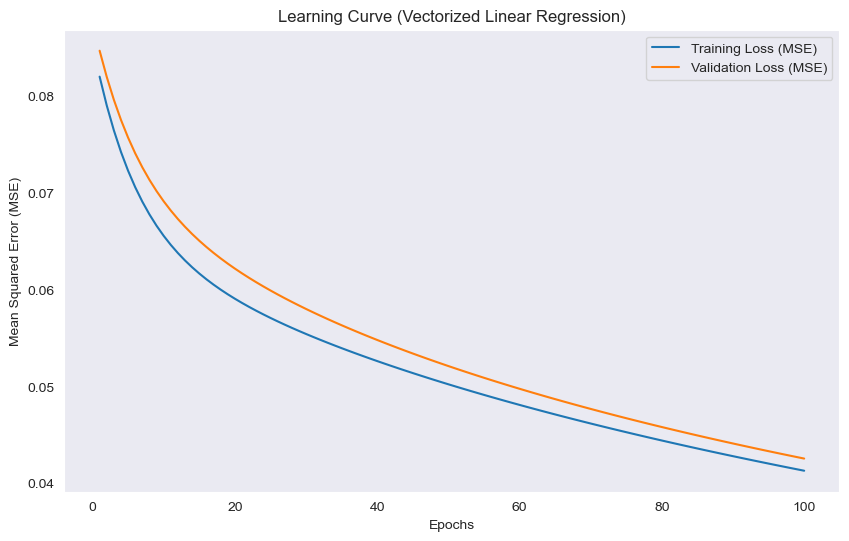

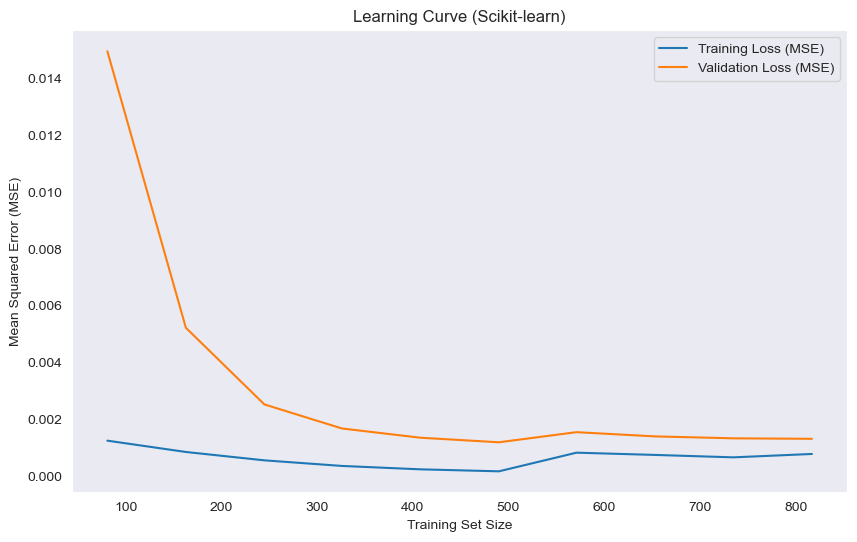

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
dataset_path = 'scaled_dataset.csv'
df = pd.read_csv(dataset_path)

X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# K-Fold Cross-Validation (Validation set is selected in each fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (Degree=2)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

# Train and evaluate models using K-Fold Cross-Validation
results = {}
for name, model in models.items():
    mae_list, mse_list, rmse_list, r2_list = [], [], [], []

    for train_idx, val_idx in kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae_list.append(mean_absolute_error(y_val, y_pred))
        mse_list.append(mean_squared_error(y_val, y_pred))
        rmse_list.append(np.sqrt(mse_list[-1]))
        r2_list.append(r2_score(y_val, y_pred))

    results[name] = (np.mean(mae_list), np.mean(mse_list), np.mean(rmse_list), np.mean(r2_list))

# Display results
print("\nModel Performance on Validation Set (K-Fold CV):")
for name, (mae, mse, rmse, r2) in results.items():
    print(f"{name}:\n  MAE: {mae:.4f}\n  MSE: {mse:.4f}\n  RMSE: {rmse:.4f}\n  R2 Score: {r2:.4f}\n")

# Select best model (highest average R2 score)
best_model_name = max(results, key=lambda x: results[x][3])
best_model = models[best_model_name]
print(f"Best Model Before Tuning: {best_model_name}\n")

# Hyperparameter tuning for the best model
if isinstance(best_model, Ridge) or isinstance(best_model, Lasso):
    param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
elif "Polynomial" in best_model_name:
    param_grid = {"polynomialfeatures__degree": [2, 3, 4]}
else:
    param_grid = {}

if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_val, y_train_val)
    tuned_model = grid_search.best_estimator_

    # Training Error
    y_train_pred = tuned_model.predict(X_train_val)
    train_mae = mean_absolute_error(y_train_val, y_train_pred)
    train_mse = mean_squared_error(y_train_val, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_val, y_train_pred)

    # Test Error
    y_test_pred = tuned_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nModel Performance After Tuning:")
    print(f"{best_model_name} (Training Set):")
    print(f"  MAE: {train_mae:.4f}\n  MSE: {train_mse:.4f}\n  RMSE: {train_rmse:.4f}\n  R2 Score: {train_r2:.4f}\n")

    print(f"{best_model_name} (Test Set):")
    print(f"  MAE: {test_mae:.4f}\n  MSE: {test_mse:.4f}\n  RMSE: {test_rmse:.4f}\n  R2 Score: {test_r2:.4f}\n")

    print(f"Best Parameters: {grid_search.best_params_}")

# ====================================================
# 1. Vectorized Linear Regression Model with Gradient Descent
# ====================================================

class VectorizedLinearRegression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        self.train_loss = []
        self.val_loss = []

        for epoch in range(self.epochs):
            # Predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Track training loss
            train_mse = mean_squared_error(y, y_pred)
            self.train_loss.append(train_mse)

            # Track validation loss (if validation set is provided)
            if hasattr(self, 'X_val'):
                y_val_pred = np.dot(self.X_val, self.weights) + self.bias
                val_mse = mean_squared_error(self.y_val, y_val_pred)
                self.val_loss.append(val_mse)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Prepare data for vectorized linear regression
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Train vectorized linear regression
vectorized_model = VectorizedLinearRegression(learning_rate=0.01, epochs=100)
vectorized_model.X_val = X_val  # Pass validation set
vectorized_model.y_val = y_val
vectorized_model.fit(X_train, y_train)

# Plot learning curve for vectorized model
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), vectorized_model.train_loss, label="Training Loss (MSE)")
plt.plot(range(1, 101), vectorized_model.val_loss, label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve (Vectorized Linear Regression)")
plt.legend()
plt.grid()
plt.show()

# ====================================================
# 2. Scikit-learn Learning Curve
# ====================================================

# Use the best model for learning curve
train_sizes, train_scores, val_scores = learning_curve(
    tuned_model, X_train_val, y_train_val, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert scores to positive MSE
train_scores_mse = -train_scores.mean(axis=1)
val_scores_mse = -val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mse, label="Training Loss (MSE)")
plt.plot(train_sizes, val_scores_mse, label="Validation Loss (MSE)")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve (Scikit-learn)")
plt.legend()
plt.grid()
plt.show()